In [25]:
import onnxruntime as ort # to inference ONNX models, we use the ONNX Runtime
import numpy as np
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import torch
from helper import *

In [26]:
def training_filter_multiple_jets(jets, electrons, muons, genparts, mets):
    '''
    Filters events down to training set and calculates jet-level labels
    
    Args:
        jets: selected jets after region filter (and selecting leading four for each event)
        electrons: selected electrons after region filter
        muons: selected muons after region filter
        genparts: selected genpart after region filter
        even: whether the event is even-numbered (used to separate training events)
    
    Returns:
        jets: selected jets after training filter
        electrons: selected electrons after training filter
        muons: selected muons after training filter
        labels: labels of jets within an event (24=W, 6=top_hadron, -6=top_lepton)
        even: whether the event is even-numbered
    '''
    #### filter genPart to valid matching candidates ####

    # get rid of particles without parents
    genpart_parent = genparts.distinctParent
    genpart_filter = np.invert(ak.is_none(genpart_parent, axis=1))
    genparts = genparts[genpart_filter]
    genpart_parent = genparts.distinctParent

    # ensure that parents are top quark or W
    genpart_filter2 = ((np.abs(genpart_parent.pdgId)==6) | (np.abs(genpart_parent.pdgId)==24))
    genparts = genparts[genpart_filter2]

    # ensure particle itself is a quark
    genpart_filter3 = ((np.abs(genparts.pdgId)<7) & (np.abs(genparts.pdgId)>0))
    genparts = genparts[genpart_filter3]

    # get rid of duplicates
    genpart_filter4 = genparts.hasFlags("isLastCopy")
    genparts = genparts[genpart_filter4]
            
        
    #### get jet-level labels and filter events to training set
        
    # match jets to nearest valid genPart candidate
    nearest_genpart = jets.nearest(genparts, threshold=0.4)
    nearest_parent = nearest_genpart.distinctParent # parent of matched particle
    parent_pdgid = nearest_parent.pdgId # pdgId of parent particle
    grandchild_pdgid = nearest_parent.distinctChildren.distinctChildren.pdgId # pdgId of particle's parent's grandchildren

    grandchildren_flat = np.abs(ak.flatten(grandchild_pdgid,axis=-1)) # flatten innermost axis for convenience

    # if particle has a cousin that is a lepton
    has_lepton_cousin = (ak.sum(((grandchildren_flat%2==0) & (grandchildren_flat>10) & (grandchildren_flat<19)),
                                axis=-1)>0)
    # if particle has a cousin that is a neutrino
    has_neutrino_cousin = (ak.sum(((grandchildren_flat%2==1) & (grandchildren_flat>10) & (grandchildren_flat<19)),
                                  axis=-1)>0)

    # if a particle has a lepton cousin and a neutrino cousin
    has_both_cousins = ak.fill_none((has_lepton_cousin & has_neutrino_cousin), False) #not using .to_numpy bc inregular array size (different event level, multiple jets)

    # get labels from parent pdgId (fill none with 100 to filter out events with those jets)
    labels = np.abs(ak.fill_none(parent_pdgid,100)) #not using .to_numpy bc inregular array size (different event level, multiple jets)

    # changing the labels while still preserve awkward array jets. To bypass inplace assignment error of numpy_array vs awkward_array
    new_labels = ak.Array([])
    for idx in range(len(labels)):
        (labels[idx].to_numpy())[has_both_cousins[idx].to_numpy()]=-6
        new_labels = ak.concatenate([new_labels, ak.Array([labels[idx]])], axis=0)
    labels = new_labels
    
    #mask for event validation (atleast 4 jets with -6, 6, 24, 24, 100, 100,...)
    mask = ak.Array([])
    for idx in range(len(labels)):
        event_valid_bool = (ak.sum(labels[idx]==-6)==1) & (ak.sum(labels[idx]==6)==1) & (ak.sum(labels[idx]==24)==2)
        mask = ak.concatenate([mask, ak.Array([event_valid_bool])], axis=0)
            
    # filter events
    jets = jets[mask]
    electrons = electrons[mask]
    muons = muons[mask]
    labels = labels[mask]
    mets = mets[mask]
    
    return jets, electrons, muons, mets, labels


def random_assignment(jet_level_mask):
    """
    Generates random unique indices for 'lt' and 'ht' for each event, excluding index 0 (lepton).
    
    Parameters:
    mask (np.array): Boolean tensor of shape [N, 17] indicating real jets (True) and fake jets (False).

    Returns:
    dict: A dictionary with keys 'lt' and 'ht' containing the randomly generated indices.
    """
    num_events = jet_level_mask.shape[0]
    assignments = {'lt':[], 'ht':[]}
    for i in range(num_events):
        real_jet_indices = np.where(jet_level_mask[i])[0] #getting real jets indices [0, 1, 2, 3, 4,...]
        real_jet_indices = real_jet_indices[real_jet_indices != 0] #exclude 0 index out of random indices because lepton indices is always one. We want leptonic/hadronic top quarks

        chosen_indices = np.random.choice(real_jet_indices, size=4, replace=False) #technically rearrange, assign random indices
        lt_index = chosen_indices[0]
        ht_indices = chosen_indices[1:]

        assignments['lt'].append([lt_index])
        assignments['ht'].append(ht_indices)

    # Convert lists to numpy arrays
    assignments['lt'] = np.array(assignments['lt'])
    assignments['ht'] = np.array(assignments['ht'])
    
    return assignments

def log_normalize(x):
    return np.log(x+1)

In [27]:
# # Load the ONNX model
onnx_model_path = "./spanet.onnx"
session = ort.InferenceSession(onnx_model_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

In [5]:
# print("Inputs:", [input.name for input in session.get_inputs()])
# print("Outputs:", [output.name for output in session.get_outputs()])

In [28]:
# Input preprocessing

#Coffea Events importing
file_path = 'https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_70000_0000.root'
tree_name = "Events"
events = NanoEventsFactory.from_root(file_path, treepath=tree_name, entry_start=None, entry_stop=None, schemaclass=NanoAODSchema).events()

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(


In [29]:
selected_electrons = events.Electron[(events.Electron.pt > 30) & (np.abs(events.Electron.eta)<2.1) & 
                                        (events.Electron.cutBased==4) & (events.Electron.sip3d < 4)]
selected_muons = events.Muon[(events.Muon.pt > 30) & (np.abs(events.Muon.eta)<2.1) & (events.Muon.tightId) & 
                                (events.Muon.sip3d < 4) & (events.Muon.pfRelIso04_all < 0.15)]

selected_genpart = events.GenPart # for label calcualtion later
selected_MET = events.MET # Part of SPANet features (global feature)

jet_filter = (events.Jet.pt > 30) & (np.abs(events.Jet.eta) < 2.4) & (events.Jet.isTightLeptonVeto) #Jet filter
selected_jets = events.Jet[jet_filter]

In [30]:
# single lepton requirement
event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
# require at least 4 jets
event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
# require at least one jet above B_TAG_THRESHOLD
B_TAG_THRESHOLD = 0.5
event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)

# apply event filters
selected_electrons = selected_electrons[event_filters]
selected_muons = selected_muons[event_filters]
selected_jets = selected_jets[event_filters]
selected_genpart = selected_genpart[event_filters]
selected_MET = selected_MET[event_filters]

### only consider 4j2b (signal) region
region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2 # at least two b-tagged jets
selected_jets_region = selected_jets[region_filter] # all jet
selected_electrons_region = selected_electrons[region_filter]
selected_muons_region = selected_muons[region_filter]
selected_genpart_region = selected_genpart[region_filter]
selected_MET_region = selected_MET[region_filter]

In [31]:
#getting labels for valid event
jets, electrons, muons, mets, labels = training_filter_multiple_jets(selected_jets_region, selected_electrons_region, selected_muons_region, selected_genpart_region, selected_MET_region)

In [32]:
#jets
jets_btag = jets.btagCSVV2 #awkward array (not padded yet)
jets_mass = jets.mass
jets_pt = jets.pt
jets_eta = jets.eta
jets_sin_phi = np.sin(jets.phi)
jets_cos_phi = np.cos(jets.phi)

#Met
mets_sumEt = mets.sumEt #awkward array (no padded needed)
mets_sin_phi = np.sin(mets.phi)
mets_cos_phi = np.cos(mets.phi)

In [33]:
num_events = ak.num(jets, axis=0)

#initializing (for memory allocation)
leptons_btag = np.zeros(num_events)
leptons_mass = np.zeros(num_events)
leptons_pt = np.zeros(num_events)
leptons_eta = np.zeros(num_events)
leptons_sin_phi = np.zeros(num_events)
leptons_cos_phi = np.zeros(num_events)

# creating lepton mask (either one electron or one muon)
has_electron = ak.num(electrons, axis=1) > 0
has_muon = ak.num(muons, axis=1) > 0

#filling electrons features from events
leptons_mass[has_electron] = electrons.mass[has_electron][:, 0]
leptons_pt[has_electron] = electrons.pt[has_electron][:, 0]
leptons_eta[has_electron] = electrons.eta[has_electron][:, 0]
leptons_sin_phi[has_electron] = np.sin(electrons.phi[has_electron][:, 0])
leptons_cos_phi[has_electron] = np.cos(electrons.phi[has_electron][:, 0])
#fillinig  muons features from events
leptons_mass[has_muon] = muons.mass[has_muon][:, 0]
leptons_pt[has_muon] = muons.pt[has_muon][:, 0]
leptons_eta[has_muon] = muons.eta[has_muon][:, 0]
leptons_sin_phi[has_muon] = np.sin(muons.phi[has_muon][:, 0])
leptons_cos_phi[has_muon] = np.cos(muons.phi[has_muon][:, 0])

In [34]:
# Combining momenta (leptons + jets)
# max_num_jets = ak.max(ak.num(jets, axis=1))
max_num_jets = 16 # +1 electrons

momenta_btag = np.zeros((num_events, max_num_jets + 1)) #initializing 2d array. num_events*(max_num_jets+1 lepton) (padded)
momenta_mass = np.zeros((num_events, max_num_jets + 1))
momenta_pt = np.zeros((num_events, max_num_jets + 1))
momenta_eta = np.zeros((num_events, max_num_jets + 1))
momenta_sin_phi = np.zeros((num_events, max_num_jets + 1))
momenta_cos_phi = np.zeros((num_events, max_num_jets + 1))

#the 0th argument from lepton information
momenta_btag[:, 0] = leptons_btag #no btag for electron. Thus, all zero.
momenta_mass[:, 0] = leptons_mass
momenta_pt[:, 0] = leptons_pt
momenta_eta[:, 0] = leptons_eta
momenta_sin_phi[:, 0] = leptons_sin_phi
momenta_cos_phi[:, 0] = leptons_cos_phi

#filling jets into momenta
for idx in range(max_num_jets): #going through jets level
    mask = ak.num(jets, axis=1) > idx #filtering events that has num_jets > idx
    momenta_btag[mask, idx + 1] = jets_btag[mask][:, idx]
    momenta_mass[mask, idx + 1] = jets_mass[mask][:, idx]
    momenta_pt[mask, idx + 1] = jets_pt[mask][:, idx]
    momenta_eta[mask, idx + 1] = jets_eta[mask][:, idx]
    momenta_sin_phi[mask, idx + 1] = jets_sin_phi[mask][:, idx]
    momenta_cos_phi[mask, idx + 1] = jets_cos_phi[mask][:, idx]

momenta_MASK = momenta_mass != 0 #this should valid (since mass would never be zero -> jets/leptons exist)

#convert met to numpy
mets_sumEt = mets_sumEt.to_numpy()
mets_sin_phi = mets_sin_phi.to_numpy()
mets_cos_phi = mets_cos_phi.to_numpy()

In [35]:
### TRAGET indices ###
#ht
b_had_indices = np.zeros(num_events, dtype=int)
q1_indices = np.zeros(num_events, dtype=int)
q2_indices = np.zeros(num_events, dtype=int)
#lt
b_lep_indices = np.zeros(num_events, dtype=int)
l_indices = np.zeros(num_events, dtype=int)

b_lep_indices[:] = ak.argmax(labels == -6, axis=1) + 1 #avoiding for-loop since there is exact one -6 and one 6
b_had_indices[:] = ak.argmax(labels == 6, axis=1) + 1
  
# Find indices for 24
for idx, event in enumerate(labels):
    q_indices = ak.where(event == 24)[0]
    q1_indices[idx] = q_indices[0] + 1
    q2_indices[idx] = q_indices[1] + 1

#TARGETS
ht_target = {
    'b': b_had_indices,
    'q1': q1_indices,
    'q2': q2_indices,
}

lt_target = {
    'b': b_lep_indices,
    'l': l_indices,
}

In [36]:
momenta_mass.shape

(8995, 17)

In [43]:
# Constructing inputs according to model shape
num_event_limit = 7000

# Combine all momenta into a single data array
# doing log-normalize
Momenta_data = np.stack([
#     momenta_mass[:num_event_limit], #
#     momenta_pt[:num_event_limit], 
    momenta_mass[:num_event_limit],
    momenta_pt[:num_event_limit], 
    momenta_eta[:num_event_limit], 
    momenta_sin_phi[:num_event_limit], 
    momenta_cos_phi[:num_event_limit], 
    momenta_btag[:num_event_limit]
], axis=-1)  # Shape: (8995, 17, 6)

Momenta_mask = momenta_MASK[:num_event_limit]

Met_data = np.stack([
    mets_sumEt[:num_event_limit], 
    mets_sin_phi[:num_event_limit], 
    mets_cos_phi[:num_event_limit]], 
    axis=-1)[:, np.newaxis, :]  # Shape: (8995, 1, 3)

#All true becasue each event have one MET
Met_mask = np.ones((num_event_limit, 1), dtype=bool)  # Shape: (8995, 1)
# Met_mask = np.ones((num_events, 1), dtype=bool)  # Shape: (8995, 1)

# Combine into a dictionary for ONNX model input
inputs = {
    "Momenta_data": Momenta_data.astype(np.float32),  # Shape: (8995, 17, 6)
    "Momenta_mask": Momenta_mask.astype(np.bool_),  # Shape: (8995, 17)
    "Met_data": Met_data.astype(np.float32),       # Shape: (8995, 1, 3)
    "Met_mask": Met_mask.astype(np.bool_)        # Shape: (8995, 1)
}

### Inputs: ['Momenta_data', 'Momenta_mask', 'Met_data', 'Met_mask']

In [44]:
Momenta_data.shape

(7000, 17, 6)

In [45]:
# Running inference on onnx
outputs = session.run(None, inputs)
### Outputs: ['lt_assignment_log_probability', 'ht_assignment_log_probability', 'lt_detection_log_probability', 'ht_detection_log_probability']

In [46]:
# outputs[0].shape # 'lt_assignment_log_probability' (num_event, num_decay_products)

(7000, 17)

In [47]:
# outputs[1].shape # 'ht_assignment_log_probability' (num_event, num_decay_products)

(7000, 17, 17, 17)

In [48]:
lt_assignment_probability = np.exp(outputs[0]) # (num_events, 17, 17, 17), convert to normal probability 
ht_assignment_probability = np.exp(outputs[1]) # (num_events, 17, 17, 17), convert to normal probability 

In [49]:
# Finding indices for a leptonic top with highest probability
lt_predicted_indices = np.argmax(lt_assignment_probability, axis=1) #ruturn shape would be (number of event,)

In [50]:
lt_predicted_indices = (torch.tensor(lt_predicted_indices, dtype=torch.int)).unsqueeze(1)

In [51]:
#Finding indices for three hadronic tops with the highest probability
#each event has (17, 17, 17) probability distribution indicating the likelihood of three jets combination 
# forming haddronic top quark
ht_predicted_indices = [
    np.unravel_index(np.argmax(ht_assignment_probability[i]), (17, 17, 17))
    for i in range(num_event_limit)
]

In [52]:
#convert array to tensor so that can use SPANet plotting function
ht_predicted_indices = torch.tensor(ht_predicted_indices, dtype=torch.long)

In [53]:
ht_mask = torch.full((num_event_limit,), True, dtype=torch.bool)
lt_mask = torch.full((num_event_limit,), True, dtype=torch.bool)

In [ ]:
#PLOTTING

In [54]:
#Momenta_input needs to have log-normalization for mass and pt (to use invariant mass function in helper.py)
Momenta_inputs = np.stack([
    log_normalize(momenta_mass[:num_event_limit]),
    log_normalize(momenta_pt[:num_event_limit]), 
    momenta_eta[:num_event_limit], 
    momenta_sin_phi[:num_event_limit], 
    momenta_cos_phi[:num_event_limit], 
    momenta_btag[:num_event_limit]
], axis=-1)  # Shape: (8995, 17, 6)

In [55]:
Momenta_inputs.shape

(7000, 17, 6)

In [56]:
#converting np array to tensor
Momenta = torch.tensor(Momenta_inputs, dtype=torch.float32)
lt_truth = (torch.tensor(lt_target['b'][:num_event_limit], dtype=torch.long)).unsqueeze(1)

In [57]:
ht_truth_stack = np.stack([ht_target['b'][:num_event_limit], ht_target['q1'][:num_event_limit], ht_target['q2'][:num_event_limit]], axis=1)
ht_truth = torch.tensor(ht_truth_stack, dtype=torch.long)

In [58]:
random_evaluation = random_assignment(torch.tensor(Momenta_mask, dtype=torch.bool)) #tensor argument not np

In [59]:
lt_momenta_true = assignment_index(Momenta, lt_truth, lt_mask) #extract information of leptonic top jet information
lt_momenta_pred = assignment_index(Momenta, lt_predicted_indices, lt_mask)
lt_momenta_rand = assignment_index(Momenta, random_evaluation['lt'], lt_mask)

ht_momenta_true = assignment_index(Momenta, ht_truth, ht_mask)
ht_momenta_pred = assignment_index(Momenta, ht_predicted_indices, ht_mask)
ht_momenta_rand = assignment_index(Momenta, random_evaluation['ht'], ht_mask)

In [40]:
# Momenta_data[0][0]

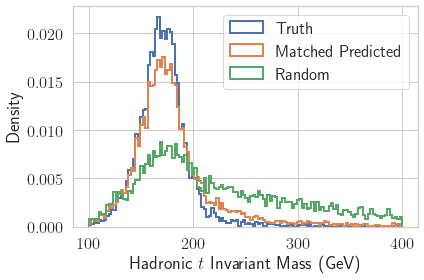

In [60]:
plot_distribution(invariant_mass(ht_momenta_true), line=2, label="Truth", range=(100, 400))
plot_distribution(invariant_mass(ht_momenta_pred), line=2, label="Matched Predicted", range=(100, 400))
plot_distribution(invariant_mass(ht_momenta_rand), line=2, label="Random", range=(100, 400))

plt.xlabel("Hadronic $t$ Invariant Mass (GeV)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout();